# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

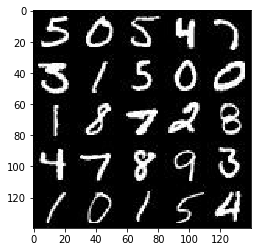

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

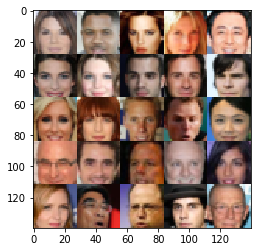

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [33]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        layer1 = tf.layers.conv2d(images, 64, 5, 2, padding='same')
        h1 = tf.maximum(0.2 * layer1, layer1)

        layer2 = tf.layers.conv2d(h1, 128, 5, 2, padding='same')
        b2 = tf.layers.batch_normalization(layer2, training=True)
        h2 = tf.maximum(0.2 * b2, b2)

        layer3 = tf.layers.conv2d(h2, 256, 5, 2, padding='same')
        b3 = tf.layers.batch_normalization(layer3, training=True)
        h3 = tf.maximum(0.2 * b3, b3)

        flatten_input = tf.reshape(h3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flatten_input, 1)
        logits = tf.layers.dropout(logits, rate=0.5)
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [34]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        h1 = tf.layers.dense(z, 2 * 2 * 512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(0.2 * h1, h1)

        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, padding='valid')
        b2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(b2, 0.2 * b2)

        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, padding='same')
        b3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(b3, (0.2 * b3))

        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [35]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)

    d_out_real, d_logits_real = discriminator(input_real)
    d_out_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                 logits=d_logits_real, labels=tf.ones_like(d_out_real)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_out_fake)))

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_out_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [36]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator') ]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    

    #d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)    
    with tf.control_dependencies(update_ops):
    #g_ops = [opt for opt in ops if opt.name.startswith('generator')]
    #with tf.control_dependencies(g_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
        
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [37]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [38]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
  
    _, image_width, image_height, image_channels = data_shape
    real_input, z_input, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    
    n_images = 25
    losses = []
    show_period = 100
    print_period = 10
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z_sample, lr: learning_rate, real_input: batch_images})
                
                if steps % print_period == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_period == 0:
                    show_generator_output(sess, n_images, z_input, image_channels, data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.3919... Generator Loss: 0.1037
Epoch 1/2... Discriminator Loss: 0.8160... Generator Loss: 0.6160
Epoch 1/2... Discriminator Loss: 0.4224... Generator Loss: 1.1146
Epoch 1/2... Discriminator Loss: 0.2686... Generator Loss: 15.0811
Epoch 1/2... Discriminator Loss: 0.4739... Generator Loss: 2.2538
Epoch 1/2... Discriminator Loss: 2.2397... Generator Loss: 0.2172
Epoch 1/2... Discriminator Loss: 1.1522... Generator Loss: 0.6000
Epoch 1/2... Discriminator Loss: 0.6942... Generator Loss: 0.9058
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 0.3492
Epoch 1/2... Discriminator Loss: 0.2420... Generator Loss: 2.4625


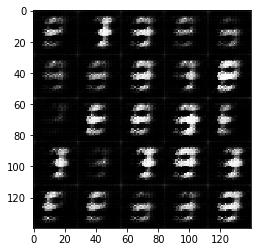

Epoch 1/2... Discriminator Loss: 1.1969... Generator Loss: 0.4837
Epoch 1/2... Discriminator Loss: 0.8589... Generator Loss: 0.7881
Epoch 1/2... Discriminator Loss: 0.3527... Generator Loss: 5.3608
Epoch 1/2... Discriminator Loss: 0.5848... Generator Loss: 1.2578
Epoch 1/2... Discriminator Loss: 0.3780... Generator Loss: 4.1260
Epoch 1/2... Discriminator Loss: 0.9386... Generator Loss: 5.9651
Epoch 1/2... Discriminator Loss: 0.3056... Generator Loss: 2.0603
Epoch 1/2... Discriminator Loss: 0.6744... Generator Loss: 2.9407
Epoch 1/2... Discriminator Loss: 0.5890... Generator Loss: 3.5480
Epoch 1/2... Discriminator Loss: 0.6611... Generator Loss: 2.2278


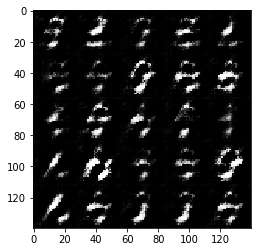

Epoch 1/2... Discriminator Loss: 0.6893... Generator Loss: 2.8797
Epoch 1/2... Discriminator Loss: 0.3992... Generator Loss: 1.6318
Epoch 1/2... Discriminator Loss: 0.8032... Generator Loss: 0.9633
Epoch 1/2... Discriminator Loss: 1.1554... Generator Loss: 0.6309
Epoch 1/2... Discriminator Loss: 0.7799... Generator Loss: 1.6936
Epoch 1/2... Discriminator Loss: 0.7940... Generator Loss: 1.0994
Epoch 1/2... Discriminator Loss: 0.8119... Generator Loss: 2.6032
Epoch 1/2... Discriminator Loss: 1.6154... Generator Loss: 0.4470
Epoch 1/2... Discriminator Loss: 1.3132... Generator Loss: 0.8289
Epoch 1/2... Discriminator Loss: 1.1893... Generator Loss: 0.6250


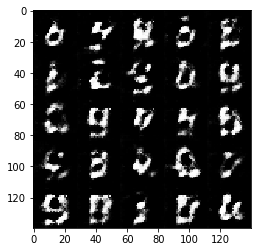

Epoch 1/2... Discriminator Loss: 1.3190... Generator Loss: 0.6744
Epoch 1/2... Discriminator Loss: 1.1024... Generator Loss: 2.2199
Epoch 1/2... Discriminator Loss: 0.9886... Generator Loss: 0.7333
Epoch 1/2... Discriminator Loss: 1.5537... Generator Loss: 0.4189
Epoch 1/2... Discriminator Loss: 1.2007... Generator Loss: 2.4697
Epoch 1/2... Discriminator Loss: 0.9368... Generator Loss: 2.2180
Epoch 1/2... Discriminator Loss: 0.7590... Generator Loss: 1.6983
Epoch 1/2... Discriminator Loss: 1.0309... Generator Loss: 0.8126
Epoch 1/2... Discriminator Loss: 1.7983... Generator Loss: 0.2750
Epoch 1/2... Discriminator Loss: 0.9866... Generator Loss: 0.8795


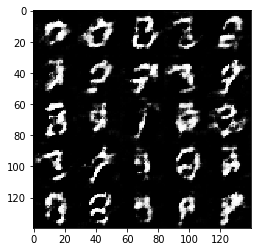

Epoch 1/2... Discriminator Loss: 0.9277... Generator Loss: 1.4151
Epoch 1/2... Discriminator Loss: 1.1876... Generator Loss: 1.7890
Epoch 1/2... Discriminator Loss: 1.0084... Generator Loss: 1.7978
Epoch 1/2... Discriminator Loss: 0.9778... Generator Loss: 0.8116
Epoch 1/2... Discriminator Loss: 1.0670... Generator Loss: 0.6758
Epoch 1/2... Discriminator Loss: 1.4197... Generator Loss: 0.3896
Epoch 1/2... Discriminator Loss: 1.0473... Generator Loss: 0.9659
Epoch 1/2... Discriminator Loss: 1.2658... Generator Loss: 2.5676
Epoch 1/2... Discriminator Loss: 0.9997... Generator Loss: 0.9921
Epoch 1/2... Discriminator Loss: 1.3567... Generator Loss: 1.7454


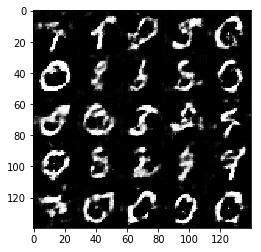

Epoch 1/2... Discriminator Loss: 1.2147... Generator Loss: 1.7447
Epoch 1/2... Discriminator Loss: 0.9205... Generator Loss: 0.9594
Epoch 1/2... Discriminator Loss: 1.1583... Generator Loss: 0.6025
Epoch 1/2... Discriminator Loss: 0.8839... Generator Loss: 1.1697
Epoch 1/2... Discriminator Loss: 1.0491... Generator Loss: 1.3765
Epoch 1/2... Discriminator Loss: 1.4820... Generator Loss: 2.3476
Epoch 1/2... Discriminator Loss: 1.0104... Generator Loss: 0.7477
Epoch 1/2... Discriminator Loss: 0.9805... Generator Loss: 0.7304
Epoch 1/2... Discriminator Loss: 1.0300... Generator Loss: 1.1350
Epoch 1/2... Discriminator Loss: 1.1615... Generator Loss: 1.8095


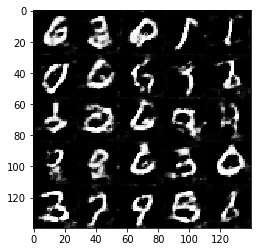

Epoch 1/2... Discriminator Loss: 0.9533... Generator Loss: 0.8895
Epoch 1/2... Discriminator Loss: 1.7051... Generator Loss: 0.2555
Epoch 1/2... Discriminator Loss: 0.9506... Generator Loss: 1.1084
Epoch 1/2... Discriminator Loss: 1.1958... Generator Loss: 1.8411
Epoch 1/2... Discriminator Loss: 1.2270... Generator Loss: 0.4928
Epoch 1/2... Discriminator Loss: 1.2676... Generator Loss: 0.5073
Epoch 1/2... Discriminator Loss: 1.4952... Generator Loss: 0.3615
Epoch 1/2... Discriminator Loss: 0.9687... Generator Loss: 0.8408
Epoch 1/2... Discriminator Loss: 0.8912... Generator Loss: 1.0873
Epoch 1/2... Discriminator Loss: 1.3404... Generator Loss: 0.4452


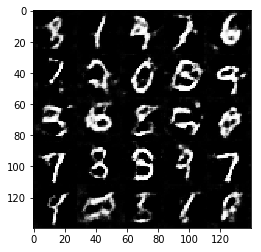

Epoch 1/2... Discriminator Loss: 1.1850... Generator Loss: 0.4967
Epoch 1/2... Discriminator Loss: 0.9853... Generator Loss: 0.8354
Epoch 1/2... Discriminator Loss: 1.0514... Generator Loss: 1.0697
Epoch 1/2... Discriminator Loss: 1.1175... Generator Loss: 1.6233
Epoch 1/2... Discriminator Loss: 1.0785... Generator Loss: 0.6431
Epoch 1/2... Discriminator Loss: 1.4978... Generator Loss: 0.3499
Epoch 1/2... Discriminator Loss: 0.9875... Generator Loss: 0.9973
Epoch 1/2... Discriminator Loss: 1.2334... Generator Loss: 0.5525
Epoch 1/2... Discriminator Loss: 1.1483... Generator Loss: 0.5269
Epoch 1/2... Discriminator Loss: 1.0337... Generator Loss: 1.2015


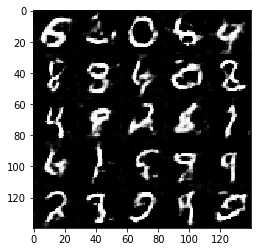

Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 0.5864
Epoch 1/2... Discriminator Loss: 0.9563... Generator Loss: 1.3635
Epoch 1/2... Discriminator Loss: 0.8796... Generator Loss: 1.2500
Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 1.9466
Epoch 1/2... Discriminator Loss: 1.0298... Generator Loss: 0.8530
Epoch 1/2... Discriminator Loss: 1.0412... Generator Loss: 0.7054
Epoch 1/2... Discriminator Loss: 0.9761... Generator Loss: 0.7058
Epoch 1/2... Discriminator Loss: 1.0778... Generator Loss: 1.7257
Epoch 1/2... Discriminator Loss: 1.1802... Generator Loss: 0.5239
Epoch 1/2... Discriminator Loss: 1.0944... Generator Loss: 0.5294


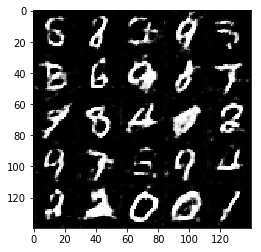

Epoch 1/2... Discriminator Loss: 1.0645... Generator Loss: 0.6160
Epoch 1/2... Discriminator Loss: 1.7427... Generator Loss: 0.2662
Epoch 1/2... Discriminator Loss: 1.0111... Generator Loss: 0.9446
Epoch 2/2... Discriminator Loss: 0.9283... Generator Loss: 1.2979
Epoch 2/2... Discriminator Loss: 0.9684... Generator Loss: 1.0351
Epoch 2/2... Discriminator Loss: 1.3309... Generator Loss: 1.7701
Epoch 2/2... Discriminator Loss: 0.9337... Generator Loss: 1.0338
Epoch 2/2... Discriminator Loss: 1.3540... Generator Loss: 0.4091
Epoch 2/2... Discriminator Loss: 0.9147... Generator Loss: 1.6656
Epoch 2/2... Discriminator Loss: 0.9524... Generator Loss: 0.7773


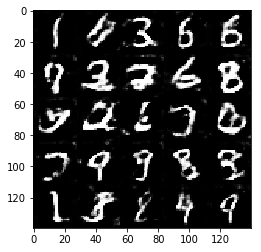

Epoch 2/2... Discriminator Loss: 0.8320... Generator Loss: 1.4369
Epoch 2/2... Discriminator Loss: 1.4230... Generator Loss: 0.3669
Epoch 2/2... Discriminator Loss: 0.8891... Generator Loss: 0.9864
Epoch 2/2... Discriminator Loss: 0.8786... Generator Loss: 1.0248
Epoch 2/2... Discriminator Loss: 0.8287... Generator Loss: 0.8062
Epoch 2/2... Discriminator Loss: 1.3152... Generator Loss: 1.9009
Epoch 2/2... Discriminator Loss: 1.2478... Generator Loss: 0.4630
Epoch 2/2... Discriminator Loss: 2.1291... Generator Loss: 0.1802
Epoch 2/2... Discriminator Loss: 0.8538... Generator Loss: 0.8799
Epoch 2/2... Discriminator Loss: 0.9484... Generator Loss: 1.0420


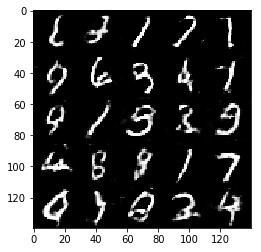

Epoch 2/2... Discriminator Loss: 1.3061... Generator Loss: 0.4468
Epoch 2/2... Discriminator Loss: 0.8298... Generator Loss: 1.1446
Epoch 2/2... Discriminator Loss: 1.1313... Generator Loss: 1.7669
Epoch 2/2... Discriminator Loss: 0.8395... Generator Loss: 1.1280
Epoch 2/2... Discriminator Loss: 0.9544... Generator Loss: 0.8054
Epoch 2/2... Discriminator Loss: 1.3331... Generator Loss: 0.3956
Epoch 2/2... Discriminator Loss: 1.1684... Generator Loss: 0.6270
Epoch 2/2... Discriminator Loss: 0.9870... Generator Loss: 0.6996
Epoch 2/2... Discriminator Loss: 1.2054... Generator Loss: 0.4863
Epoch 2/2... Discriminator Loss: 1.0435... Generator Loss: 0.6713


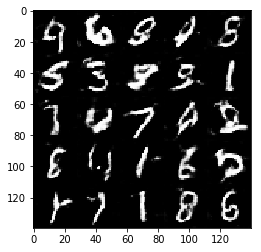

Epoch 2/2... Discriminator Loss: 2.2539... Generator Loss: 4.1283
Epoch 2/2... Discriminator Loss: 1.1084... Generator Loss: 0.5557
Epoch 2/2... Discriminator Loss: 1.8175... Generator Loss: 0.2178
Epoch 2/2... Discriminator Loss: 0.8422... Generator Loss: 0.8146
Epoch 2/2... Discriminator Loss: 1.2714... Generator Loss: 0.4305
Epoch 2/2... Discriminator Loss: 1.4341... Generator Loss: 0.3473
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 0.8684
Epoch 2/2... Discriminator Loss: 1.3873... Generator Loss: 0.4601
Epoch 2/2... Discriminator Loss: 1.2079... Generator Loss: 0.5220
Epoch 2/2... Discriminator Loss: 0.9882... Generator Loss: 0.6960


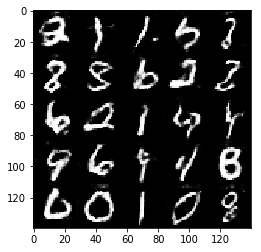

Epoch 2/2... Discriminator Loss: 0.9764... Generator Loss: 0.8547
Epoch 2/2... Discriminator Loss: 0.9044... Generator Loss: 0.8210
Epoch 2/2... Discriminator Loss: 1.5078... Generator Loss: 0.3385
Epoch 2/2... Discriminator Loss: 1.7619... Generator Loss: 0.2659
Epoch 2/2... Discriminator Loss: 1.0006... Generator Loss: 0.8803
Epoch 2/2... Discriminator Loss: 0.9476... Generator Loss: 1.3740
Epoch 2/2... Discriminator Loss: 0.8018... Generator Loss: 1.0498
Epoch 2/2... Discriminator Loss: 1.8021... Generator Loss: 3.0612
Epoch 2/2... Discriminator Loss: 0.8163... Generator Loss: 0.9950
Epoch 2/2... Discriminator Loss: 1.1433... Generator Loss: 0.5039


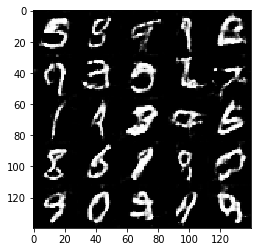

Epoch 2/2... Discriminator Loss: 1.4117... Generator Loss: 0.3770
Epoch 2/2... Discriminator Loss: 0.8689... Generator Loss: 1.7785
Epoch 2/2... Discriminator Loss: 0.9602... Generator Loss: 0.7160
Epoch 2/2... Discriminator Loss: 2.1936... Generator Loss: 0.1580
Epoch 2/2... Discriminator Loss: 0.6174... Generator Loss: 1.9352
Epoch 2/2... Discriminator Loss: 0.7882... Generator Loss: 1.3673
Epoch 2/2... Discriminator Loss: 1.0518... Generator Loss: 0.6285
Epoch 2/2... Discriminator Loss: 1.4738... Generator Loss: 2.9294
Epoch 2/2... Discriminator Loss: 1.3634... Generator Loss: 0.3815
Epoch 2/2... Discriminator Loss: 1.0304... Generator Loss: 1.4789


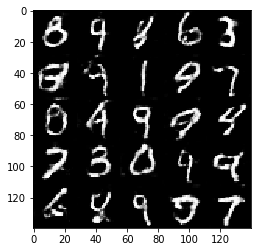

Epoch 2/2... Discriminator Loss: 0.9201... Generator Loss: 0.7055
Epoch 2/2... Discriminator Loss: 0.9194... Generator Loss: 1.1382
Epoch 2/2... Discriminator Loss: 1.2463... Generator Loss: 0.4595
Epoch 2/2... Discriminator Loss: 0.7775... Generator Loss: 0.8202
Epoch 2/2... Discriminator Loss: 1.1379... Generator Loss: 0.6193
Epoch 2/2... Discriminator Loss: 0.8334... Generator Loss: 0.9238
Epoch 2/2... Discriminator Loss: 1.1858... Generator Loss: 0.4844
Epoch 2/2... Discriminator Loss: 0.7055... Generator Loss: 1.1884
Epoch 2/2... Discriminator Loss: 0.9273... Generator Loss: 1.3160
Epoch 2/2... Discriminator Loss: 0.8296... Generator Loss: 1.0113


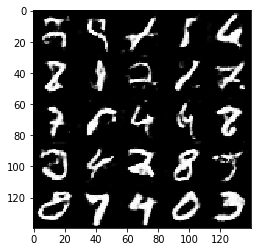

Epoch 2/2... Discriminator Loss: 1.7231... Generator Loss: 2.6383
Epoch 2/2... Discriminator Loss: 1.3949... Generator Loss: 0.3963
Epoch 2/2... Discriminator Loss: 1.1056... Generator Loss: 0.5543
Epoch 2/2... Discriminator Loss: 0.9376... Generator Loss: 2.8132
Epoch 2/2... Discriminator Loss: 1.0763... Generator Loss: 0.6363
Epoch 2/2... Discriminator Loss: 0.9847... Generator Loss: 0.6984
Epoch 2/2... Discriminator Loss: 1.0777... Generator Loss: 0.6442
Epoch 2/2... Discriminator Loss: 0.9948... Generator Loss: 0.6342
Epoch 2/2... Discriminator Loss: 0.9577... Generator Loss: 0.7438
Epoch 2/2... Discriminator Loss: 0.8861... Generator Loss: 0.7972


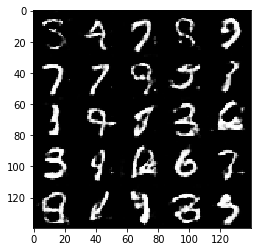

Epoch 2/2... Discriminator Loss: 1.0635... Generator Loss: 0.5786
Epoch 2/2... Discriminator Loss: 1.0935... Generator Loss: 2.3353
Epoch 2/2... Discriminator Loss: 1.4124... Generator Loss: 0.4523
Epoch 2/2... Discriminator Loss: 0.7811... Generator Loss: 1.4240
Epoch 2/2... Discriminator Loss: 0.5753... Generator Loss: 1.5293
Epoch 2/2... Discriminator Loss: 0.6700... Generator Loss: 1.6396
Epoch 2/2... Discriminator Loss: 1.3887... Generator Loss: 0.3748
Epoch 2/2... Discriminator Loss: 1.2514... Generator Loss: 0.4486
Epoch 2/2... Discriminator Loss: 1.2321... Generator Loss: 2.4281
Epoch 2/2... Discriminator Loss: 0.6508... Generator Loss: 2.3272


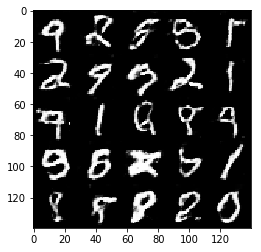

Epoch 2/2... Discriminator Loss: 1.0628... Generator Loss: 0.6192
Epoch 2/2... Discriminator Loss: 0.8932... Generator Loss: 1.4060
Epoch 2/2... Discriminator Loss: 1.7651... Generator Loss: 0.2832
Epoch 2/2... Discriminator Loss: 1.4765... Generator Loss: 0.3621
Epoch 2/2... Discriminator Loss: 0.9332... Generator Loss: 0.7394
Epoch 2/2... Discriminator Loss: 0.7186... Generator Loss: 0.9785
Epoch 2/2... Discriminator Loss: 1.0310... Generator Loss: 0.7140


In [28]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.0303... Generator Loss: 0.0696
Epoch 1/1... Discriminator Loss: 0.8038... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 0.5726... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 0.7651... Generator Loss: 7.2143
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 0.6793... Generator Loss: 4.2625
Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 5.6265
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 8.1512
Epoch 1/1... Discriminator Loss: 0.6165... Generator Loss: 1.2558
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.4777


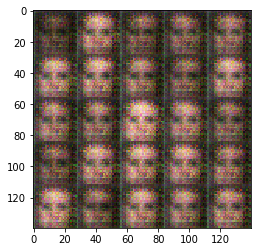

Epoch 1/1... Discriminator Loss: 0.8490... Generator Loss: 1.5179
Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 0.6209... Generator Loss: 2.2034
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 3.2945
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 1.5352
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 1.3066
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.9159


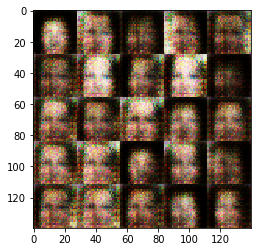

Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 1.2148
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 1.9104
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 1.3408
Epoch 1/1... Discriminator Loss: 0.6643... Generator Loss: 1.4875
Epoch 1/1... Discriminator Loss: 0.8019... Generator Loss: 2.1370
Epoch 1/1... Discriminator Loss: 0.7694... Generator Loss: 1.4890
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.4813
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 1.0826
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.5342


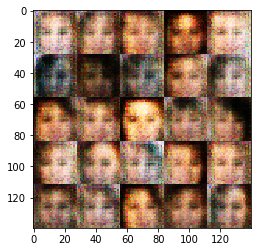

Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.9381
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 0.9686... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 1.8414
Epoch 1/1... Discriminator Loss: 1.6536... Generator Loss: 0.3079
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.5061
Epoch 1/1... Discriminator Loss: 1.7031... Generator Loss: 0.4476


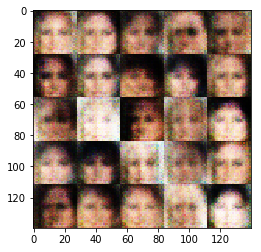

Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 1.1034
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 1.3392
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.4180
Epoch 1/1... Discriminator Loss: 1.6113... Generator Loss: 0.4202
Epoch 1/1... Discriminator Loss: 1.6436... Generator Loss: 0.3915
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.4698
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 1.5816... Generator Loss: 0.3734
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.9275


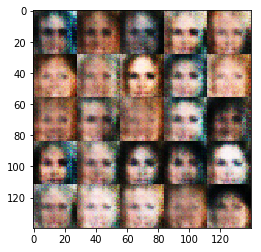

Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.7920... Generator Loss: 0.3326
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.6422... Generator Loss: 0.4606
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 1.1634
Epoch 1/1... Discriminator Loss: 1.7103... Generator Loss: 0.4557
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 1.4840


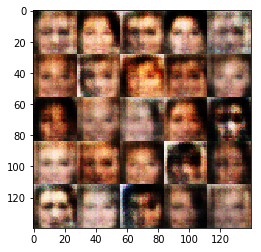

Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.4943
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.5329
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 1.0392


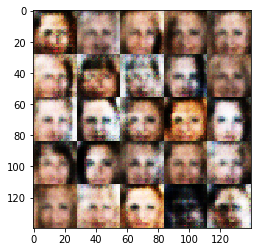

Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 1.1165
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 1.1876
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.4830
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 1.5394
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7594


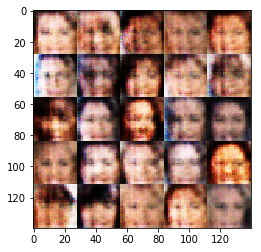

Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 1.2846
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.4389
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 1.0500
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 1.2454
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.5304
Epoch 1/1... Discriminator Loss: 1.6505... Generator Loss: 0.2932
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 1.3197
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 1.7615
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.8694


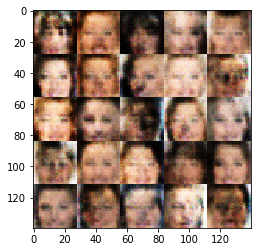

Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.5050
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 2.2085
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 1.4267
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.5018
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 1.0654
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 1.9099
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 1.3332


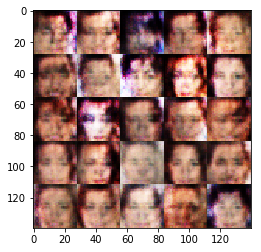

Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 1.0571
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 1.3048
Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 1.4942
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.4118
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 1.3656
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.5701
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 1.2954
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 1.4382


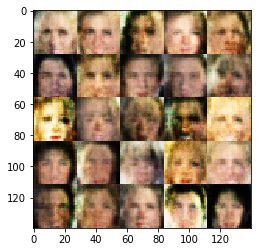

Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.5587... Generator Loss: 0.3172
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 1.1279
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.3613
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 1.5837
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 0.7843


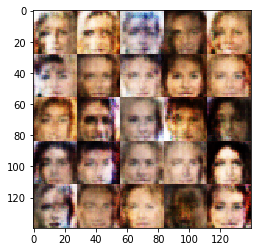

Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 1.3678
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.6161... Generator Loss: 1.3462
Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 1.1483
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.5274
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 2.1306


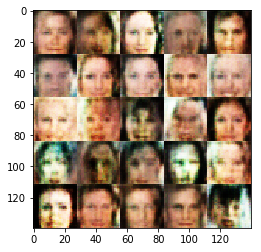

Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.6048... Generator Loss: 0.3344
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 1.1538
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.9524
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 1.0694
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.5217
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.7486


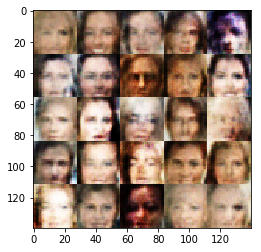

Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 1.2103
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 1.0455
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.4206
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.5221
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.4578


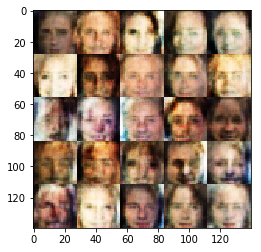

Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 1.3271
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 1.0226
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.3970
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.5718
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 1.4081
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.9458


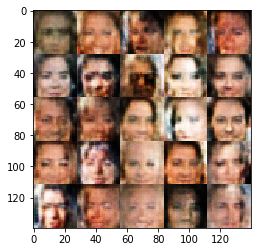

Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.4247
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 1.0507
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.4720
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.9456


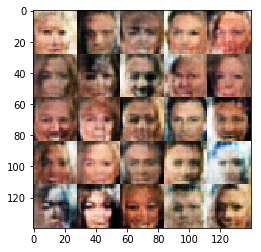

Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.3770
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 1.1866
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.5075
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 0.9066


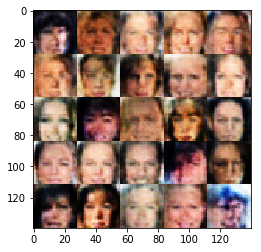

Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 1.6820
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 1.3420
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.3645
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 0.8069


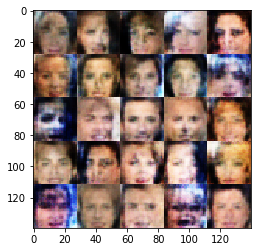

Epoch 1/1... Discriminator Loss: 1.6276... Generator Loss: 0.3499
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.4072
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.5237
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.7426


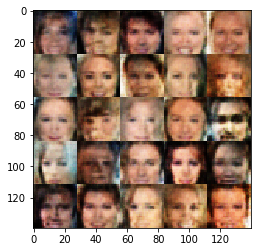

Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.5062
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.5057
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 1.1802
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.3510
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.3940
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 1.1413
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.3954


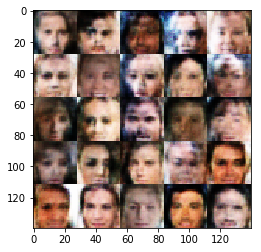

Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 1.1160
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 1.1403
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.4419
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 1.1103
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 1.0398
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 1.1905


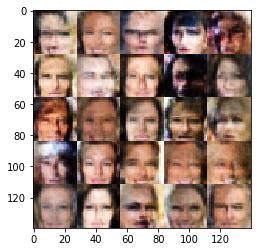

Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 1.4345
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.4372
Epoch 1/1... Discriminator Loss: 0.8623... Generator Loss: 1.2075
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.3882
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.3832
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.6947


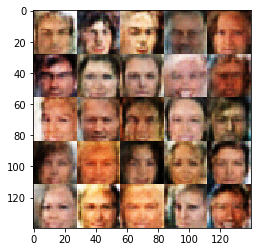

Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 1.1668
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.9207
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 1.5968
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 1.0626
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.9511


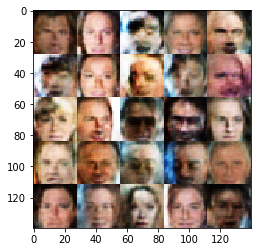

Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.7983... Generator Loss: 0.2961
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.5092
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 1.2408
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 1.0760


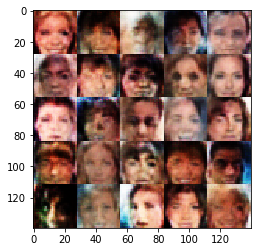

Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 1.2237
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.1746
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.4011
Epoch 1/1... Discriminator Loss: 1.5891... Generator Loss: 0.3351
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.6936... Generator Loss: 0.2875


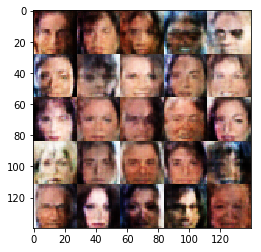

Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 1.2341
Epoch 1/1... Discriminator Loss: 0.9461... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 0.9119... Generator Loss: 1.2557
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.7206... Generator Loss: 0.2539
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.4601


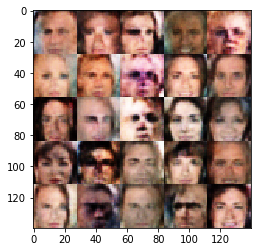

Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 1.2216
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 1.4918
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.7014


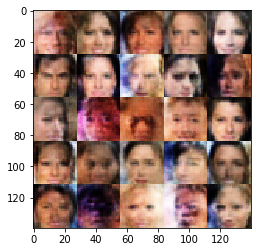

Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 1.7874... Generator Loss: 0.2513
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.3901
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 1.3830


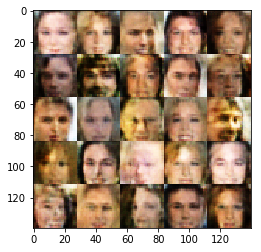

Epoch 1/1... Discriminator Loss: 1.6053... Generator Loss: 0.3323
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 1.3557
Epoch 1/1... Discriminator Loss: 0.4319... Generator Loss: 2.0248
Epoch 1/1... Discriminator Loss: 0.8453... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 1.1875
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.7685


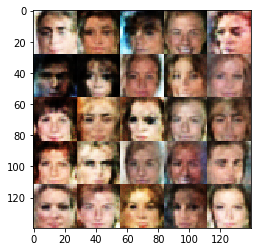

Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 1.2125
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.4662
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.5480
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.3215
Epoch 1/1... Discriminator Loss: 1.6678... Generator Loss: 0.3321


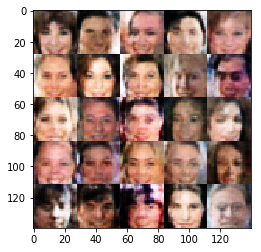

Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.4642
Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 1.2750
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 1.0976
Epoch 1/1... Discriminator Loss: 0.7185... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.0859
Epoch 1/1... Discriminator Loss: 0.8329... Generator Loss: 1.2008


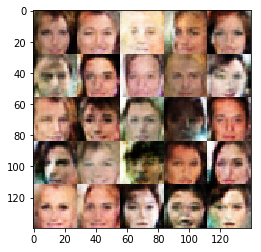

Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 1.1242
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 1.7664
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 1.2998
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.4997
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.3837
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.9232... Generator Loss: 0.2054


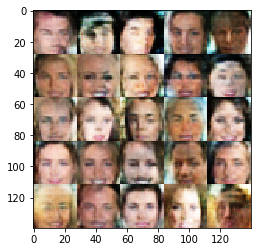

Epoch 1/1... Discriminator Loss: 1.6343... Generator Loss: 0.2866
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 1.0420
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.4105
Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.3808
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 1.1969


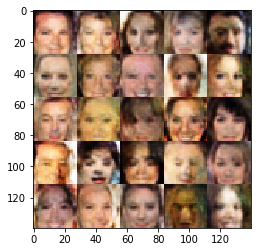

Epoch 1/1... Discriminator Loss: 1.6838... Generator Loss: 0.2676
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 1.1097
Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 1.7686... Generator Loss: 0.2456
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.4073
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.4110


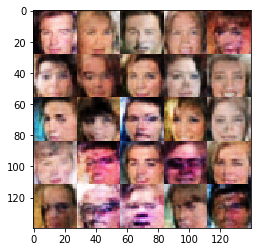

Epoch 1/1... Discriminator Loss: 0.8080... Generator Loss: 1.2754
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 2.2773
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.4835
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.3899
Epoch 1/1... Discriminator Loss: 1.7172... Generator Loss: 0.2387
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.4232
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 0.6281


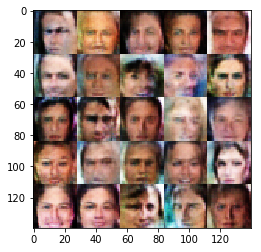

Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 1.3719
Epoch 1/1... Discriminator Loss: 0.7900... Generator Loss: 1.7793
Epoch 1/1... Discriminator Loss: 1.5844... Generator Loss: 0.3033
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.1884
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.0853
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 1.2103
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 1.0378


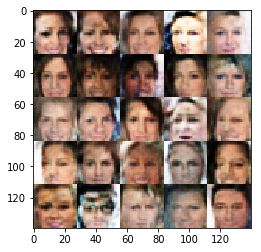

Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.3956
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 1.5324
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 0.9389... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 0.5703


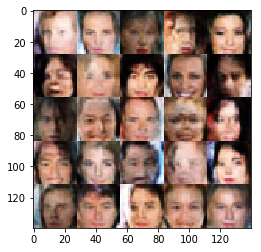

Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.7294... Generator Loss: 0.2441
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 1.1243
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.3253
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.0733
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.4143
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 0.8636


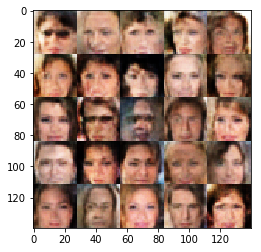

Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.3776
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 1.0494
Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 1.2106
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 0.7057... Generator Loss: 1.4611
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 1.7199
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 0.6942


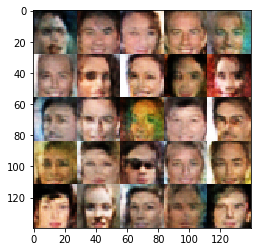

Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.5611
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 1.2288
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.3131
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.3968
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 1.0649


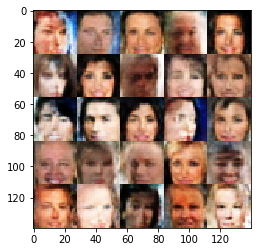

Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.4364
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.5582
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.3828
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.4097
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.3697
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.4168
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 0.6933


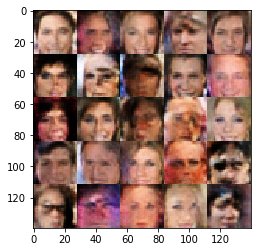

Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.3678
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.6305... Generator Loss: 0.2856
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 0.5927... Generator Loss: 1.3125
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.5386
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.5368
Epoch 1/1... Discriminator Loss: 0.8458... Generator Loss: 0.9995
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 1.0973
Epoch 1/1... Discriminator Loss: 1.8497... Generator Loss: 0.2818


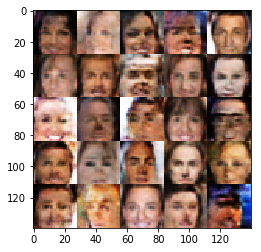

Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.3526
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.3847
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.4507


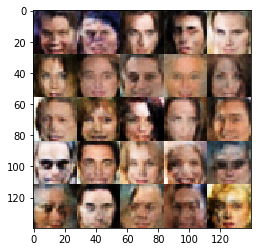

Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.4955
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.4137
Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.8259... Generator Loss: 0.2090
Epoch 1/1... Discriminator Loss: 0.7828... Generator Loss: 1.2504
Epoch 1/1... Discriminator Loss: 1.6060... Generator Loss: 0.2703


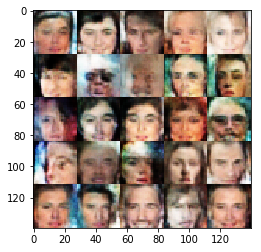

Epoch 1/1... Discriminator Loss: 1.5293... Generator Loss: 0.3097
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.4805
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 0.7059... Generator Loss: 1.1042
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.5398
Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.3821
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.4195
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.8789


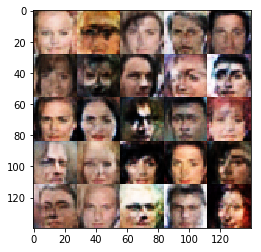

Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.4461
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 1.2445
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 1.1365
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 1.2798
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 0.9628


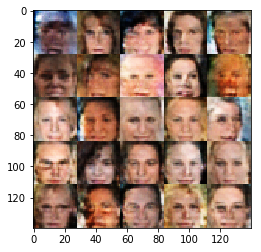

Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 0.8756... Generator Loss: 1.0059
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.3108
Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.5556
Epoch 1/1... Discriminator Loss: 0.7965... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.5326... Generator Loss: 1.5329
Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 1.1302


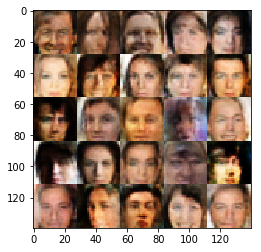

Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.4544
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 1.2867
Epoch 1/1... Discriminator Loss: 0.8202... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 0.7756... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 0.7439... Generator Loss: 1.4050
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.4719


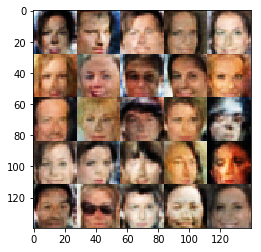

Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.9912
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 1.0871
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.5219
Epoch 1/1... Discriminator Loss: 0.7712... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.4935
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 1.3156
Epoch 1/1... Discriminator Loss: 0.7975... Generator Loss: 1.5296
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.5395


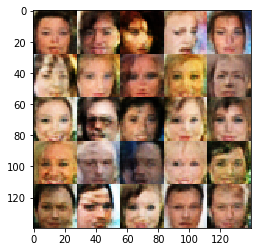

Epoch 1/1... Discriminator Loss: 0.8982... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.5698... Generator Loss: 0.3147
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 1.4526
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.4594
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.6268


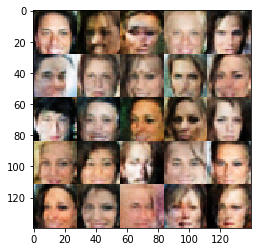

Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.4372
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.6724
Epoch 1/1... Discriminator Loss: 0.5996... Generator Loss: 1.8100
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 0.9603


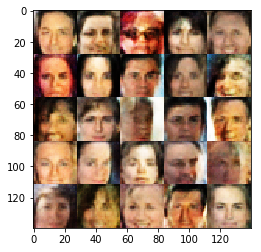

Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.4640
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.5151
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 0.8982... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 1.6628


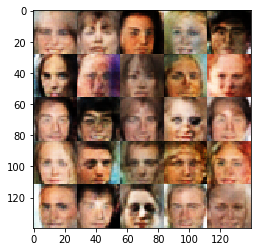

Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 1.0006
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.4512
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.4440
Epoch 1/1... Discriminator Loss: 1.7587... Generator Loss: 0.2437
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.5240


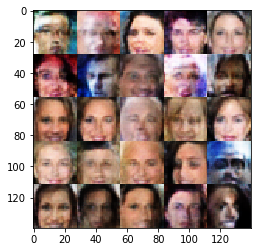

Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.5050
Epoch 1/1... Discriminator Loss: 0.9065... Generator Loss: 1.1723
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.3348
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 0.7547... Generator Loss: 1.3324
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.3312
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.7560


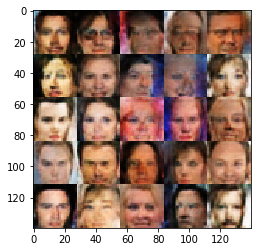

Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.4565
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.5047
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.2481
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 0.9737
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.9488... Generator Loss: 1.5352
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.8421


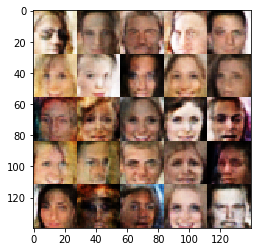

Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.4658
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.5010
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.4809
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.3658
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.4866
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 1.1925


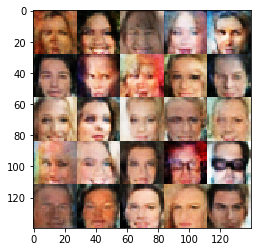

Epoch 1/1... Discriminator Loss: 0.8369... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 0.9151
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.5215


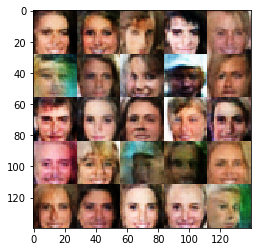

Epoch 1/1... Discriminator Loss: 1.7055... Generator Loss: 0.2769
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.9983
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 0.9410... Generator Loss: 1.2855
Epoch 1/1... Discriminator Loss: 0.6192... Generator Loss: 1.8265
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 0.7360


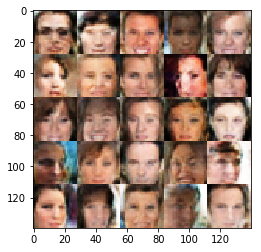

Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.4779
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.4728
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.4334
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.3350
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 0.8581


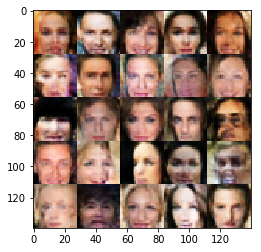

Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.9815... Generator Loss: 2.1226
Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 1.9945... Generator Loss: 0.1639
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.4705
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 1.0207


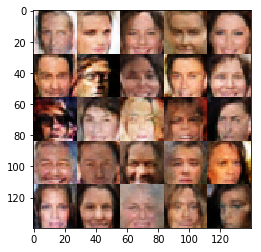

Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.7790... Generator Loss: 0.2292
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 1.5694
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 1.1596
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.6960


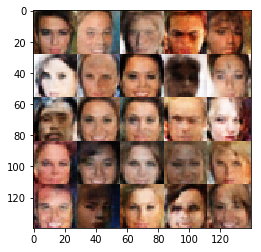

Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.7937... Generator Loss: 0.2454
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.4395
Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 1.1948
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.4919
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 0.8114


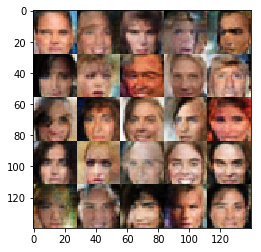

Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.4393
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.5627... Generator Loss: 0.5446


In [40]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.